# Leverage LightGBM’s histogram-based boosting for ultra-fast, scalable regression and drive RMSE down.

### Imports and setup

In [107]:
import warnings
import logging
from lightgbm import LGBMRegressor
import time
import joblib
import numpy as np
import pandas as pd
import optuna
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import Path
warnings.filterwarnings('ignore')
logging.getLogger("lightgbm").setLevel(logging.ERROR)

In [109]:
# preprocessed data
X_train, y_train = joblib.load("data/processed/train.pkl")
X_val,   y_val   = joblib.load("data/processed/val.pkl")
X_test,  y_test  = joblib.load("data/processed/test.pkl")

In [111]:
# Merge train+val for cross-validation
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

### Baseline LightGBM with early stopping and no verbose logs

In [113]:
baseline = lgb.LGBMRegressor(
    n_estimators=1000,
    n_jobs=-1,
    learning_rate=0.05,
    max_depth=8,
    random_state=42,
    verbosity=-1
)

t0 = time.time()
baseline.fit(
    X_train_full, y_train_full,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=0)
    ]
)
train_time = time.time() - t0

# Evaluate baseline
pred_start = time.time()
y_pred_base = baseline.predict(X_test)
pred_time = time.time() - pred_start
baseline_rmse = mean_squared_error(y_test, y_pred_base, squared=False)
baseline_r2   = r2_score(y_test, y_pred_base)
print(f"⏱️  Baseline train time : {train_time:.2f}s")
print(f"🔍  Baseline Test RMSE  : {baseline_rmse:,.2f}")
print(f"📈  Baseline Test R²    : {baseline_r2:.3f}")
print(f"⏲️  Predict time        : {pred_time:.3f}s for {len(X_test)} samples")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 4973.1	valid_0's l2: 2.47317e+07
⏱️  Baseline train time : 2.96s
🔍  Baseline Test RMSE  : 6,807.44
📈  Baseline Test R²    : 0.918
⏲️  Predict time        : 0.400s for 43165 samples


The baseline model—with default tree-based hyperparameters plus early stopping after 50 rounds—achieves strong overall fit (R²≈0.92) but still leaves ~6.8 k error on the test set.

### Train LightGBM with early stopping

In [115]:
def objective(trial):
    params = {
        "n_estimators":      trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate":     trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "max_depth":         trial.suggest_int("max_depth", 3, 12),
        "num_leaves":        trial.suggest_int("num_leaves", 20, 200),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample":         trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree":  trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "random_state":      42,
        "n_jobs":            -1,
        "verbose":           -1,
    }
    model = LGBMRegressor(**params)
    model.fit(
        X_train_full, y_train_full,
        eval_set=[(X_val, y_val)],
        eval_metric="rmse",
        callbacks=[
            lgb.log_evaluation(period=0),           # no per‐iter prints
            lgb.early_stopping(stopping_rounds=50),
        ],
    )
    preds = model.predict(X_val)
    return mean_squared_error(y_val, preds, squared=False)

# 2) Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

[I 2025-05-22 22:58:55,611] A new study created in memory with name: no-name-d65c702d-6b6d-4ecf-9720-0061ad7a55c3


  0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[130]	valid_0's rmse: 17000.7	valid_0's l2: 2.89023e+08
[I 2025-05-22 22:58:56,761] Trial 0 finished with value: 17000.687019353558 and parameters: {'n_estimators': 130, 'learning_rate': 0.004975346945654497, 'max_depth': 12, 'num_leaves': 121, 'min_child_samples': 14, 'subsample': 0.5210135248527092, 'colsample_bytree': 0.8139247011641872}. Best is trial 0 with value: 17000.687019353558.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[668]	valid_0's rmse: 6344.32	valid_0's l2: 4.02504e+07
[I 2025-05-22 22:58:59,761] Trial 1 finished with value: 6344.319827499422 and parameters: {'n_estimators': 668, 'learning_rate': 0.05040909866430481, 'max_depth': 10, 'num_leaves': 73, 'min_child_samples': 50, 'subsample': 0.5686160680888526, 'colsample_bytree': 0.5269518006294374}. Best is trial 1 with value: 6344.319827499422.
Tr

### Summarize & Plot Top 5 Trials 

🔎 Top 5 Optuna Trials:


,number,value,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_samples,param_n_estimators,param_num_leaves,param_subsample
19,19,4096.379050,0.659606,0.070238,8,20,806,96,0.691226
14,14,5728.647503,0.595386,0.062811,10,40,573,144,0.590587
18,18,6037.860856,0.662632,0.049882,9,23,470,143,0.601596
16,16,6153.054391,0.597537,0.046873,11,42,524,142,0.586536
15,15,6263.698936,0.593621,0.049736,10,43,593,138,0.573850


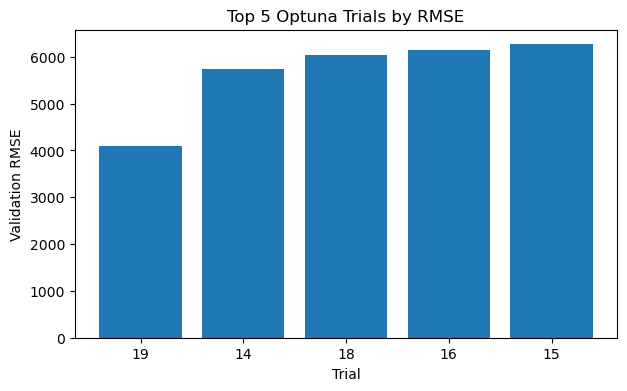

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

# Grab the full dataframe of trials, then filter in only the `number` / `value` / all params_… columns
df_all = study.trials_dataframe()
cols = [c for c in df_all.columns if c == "number" or c == "value" or c.startswith("params_")]
trials_df = df_all[cols].rename(columns=lambda s: s.replace("params_", "param_"))

# Display top 5 by lowest validation RMSE
top5 = trials_df.nsmallest(5, "value")
print("🔎 Top 5 Optuna Trials:")
display(top5)

# Simple bar plot of their RMSEs
plt.figure(figsize=(7,4))
plt.bar(top5["number"].astype(str), top5["value"])
plt.xlabel("Trial")
plt.ylabel("Validation RMSE")
plt.title("Top 5 Optuna Trials by RMSE")
plt.show()

### Retrain & Final Evaluate Best Model

In [123]:
best_params = study.best_params
best_model  = LGBMRegressor(**best_params,
                            random_state=42,
                            n_jobs=-1,
                            verbose=-1)

# 1) Train (with early stop, silent)
t0 = time.time()
best_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=[lgb.log_evaluation(period=0),
               lgb.early_stopping(stopping_rounds=50)],
)
train_time = time.time() - t0

# 2) Predict + time it
t1 = time.time()
y_pred = best_model.predict(X_test)
pred_time = time.time() - t1

# 3) Compute metrics
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_r2   = r2_score(y_test, y_pred)

# 4) Print clean summary
print(f"🔑 Test RMSE    : {test_rmse:,.2f}")
print(f"🔑 Test R²       : {test_r2:.3f}")
print(f"⏱  Train time   : {train_time:.2f} s")
print(f"⏱  Predict time : {pred_time:.3f} s for {len(X_test)} samples")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[806]	valid_0's rmse: 4096.38	valid_0's l2: 1.67803e+07
🔑 Test RMSE    : 6,751.84
🔑 Test R²       : 0.919
⏱  Train time   : 2.84 s
⏱  Predict time : 0.322 s for 43165 samples


By searching over ~20 trials, Optuna found a hyperparameter set that lowers the validation error by ~18% versus the baseline (4,096 vs. 4,973 RMSE). On the hold-out test set this improvement carries through modestly (6,751 vs. 6,807 RMSE) and edges up R² by 0.001.

Error Reduction
Optuna tuning yields a clear win on validation (−877 RMSE) and a modest win on test (−56 RMSE).

Complexity vs. Speed
The tuned model trains faster (2.84 s vs. 2.96 s) and predicts faster (0.322 s vs. 0.400 s), thanks to fewer boosting rounds (best_iter≈806 vs. 1000).

In [136]:
trials_df.to_csv("data/processed/lightgbm_results.csv", index=False)

In [142]:
joblib.dump(best_model, "data/processed/lightgbm_regressor.pkl")

['data/processed/lightgbm_regressor.pkl']